# Neural Quest Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1DF-OWSP803x34FrvaJ4XeDm_QZUevu32/view?usp=sharing)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
import math

## Load *Dataset*
Load data from the given pickle file

In [2]:
# load the data set
with open("train_data.pkl",'rb') as f:
    data = pickle.load(f)
X = data['X']
y = data['y']
print(X.shape)
# normalize
X = X/256
# print(X[0])
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

(60000, 784)


/home/khushangsingla/cs231n/.venv/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


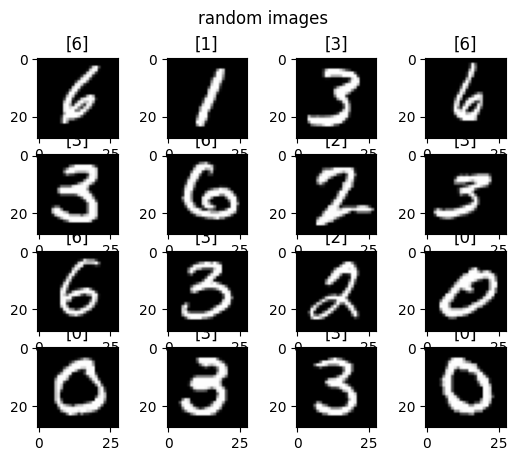

In [3]:
# display a 4x4 grid, 
# fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*i+j+1)
        idx = random.randrange(60000)
        a11 = X[idx].reshape(28,28)
        plt.title(y[idx])
        plt.imshow(a11, cmap='gray')
plt.suptitle('random images')

# choose 16 images randomly, display the images as well as corresponding labels

plt.show()

## Building up parts of our classifier

**Activation functions**

In [4]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(np.zeros(z.shape),z)
#     z = np.maximum(0,np.zeros(z.shape))
    return z

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    z1 = z -  np.max(z,axis = 1, keepdims = True)
    p = np.exp(z1)/np.sum(np.exp(z1), axis=1, keepdims = True)
    return p

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [5]:
def init_params(input_dim,hidden_dim,output_dim):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    w1 = 0.01*np.random.randn(input_dim,hidden_dim) / math.sqrt(input_dim/2)
    w2 = 0.01*np.random.randn(hidden_dim,output_dim) / math.sqrt(hidden_dim/2)
    b1 = np.zeros((hidden_dim,1))
    b2 = np.zeros((output_dim,1))
    return(w1,w2,b1,b2)

**Forward Propagation**

In [6]:
def forward_propg(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    w1,w2,b1,b2 = weights
    dense_layer = relu(X.dot(w1)+b1.T)
    output_layer = dense_layer.dot(w2)+b2.T
    return (dense_layer, output_layer)


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [7]:
def backward_propg(weights, X, y, forward_output,lr):
    """
    should update the weights and return updated weights
    """
    w1,w2,b1,b2 = weights
    dense_layer,output_layer = forward_output
    prob = softmax(output_layer)
    # intermediate_gradient = dl/do = (dl/dp)*(dp/do)
    prob[np.arange(X.shape[0]),y.T]-=1
    #prob dim = N,10
    prob /= X.shape[0]
    grad_b2 = (np.sum(prob,axis = 0, keepdims = True).T)#shape = 10,1 #b2 gradient
    grad_w2 = (dense_layer.T).dot(prob) #w2 gradient
    new_array = dense_layer>0
    grad_H = (prob.dot(w2.T))*new_array #hidden layer gradient
    grad_b1 = (np.sum(grad_H,axis = 0, keepdims = True).T)
    grad_w1 = (X.T).dot(grad_H)
    #updating the values after backpropagation
    w1 -= grad_w1*lr #lr = learning rate
    w2 -= grad_w2*lr
    b1 -= grad_b1*lr
    b2 -= grad_b2*lr
    return (w1,w2,b1,b2)

In [8]:
# def cost_func(y,prob):
def cost_func(y,output_layer):

    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    prob = softmax(output_layer)
    loss = -1*np.log(prob)
#     return loss[np.arange(prob.shape[0]),y[0]].sum()/prob.shape[0]
    return ((loss[np.arange(output_layer.shape[0]),y.T].sum())/(output_layer.shape[0]))


## Integrate everything

In [18]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5,model_params = None):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
#     print("HERE1")
    # initialize weights.
    weights = model_params
    if not model_params:
        weights = init_params(X.shape[1],hidden_nodes,10)
    for i in range(epochs):
#         print("HERE2")
        # forward propagation
        X_big,X_small,y_big,y_small = train_test_split(X,y,stratify=y,test_size = 256/45000)
        layers = forward_propg(X_small,weights)
        # print cost at every 100 or so iterations
        if((i%100)==0):
#             prob = softmax(layers[1])
            loss = cost_func(y_small,layers[1])
            print("at ",i,"th iteration loss = ",loss)
        # backward propagation
        weights = backward_propg(weights,X_small,y_small,layers,lr)
    return(weights)

In [10]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    w1,w2,b1,b2 = updated_weights
    hidden_layer = relu(X.dot(w1)+b1.T)
    scores = (hidden_layer.dot(w2)+b2.T)
    predictions = np.argmax(scores,axis = 1, keepdims=True)
    return predictions

In [11]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    correct_array = (predictions==y)
    sum_value = np.sum(correct_array)
    total = predictions.shape[0]
    print(y.shape,predictions.shape,(predictions==y[0]).sum())
    print(y[0],predictions)
    print("Accuracy = ",(sum_value/total)*100)
    return
    

In [21]:
weights = train(X_train,y_train,256,epochs=200,lr=50e-2)
weights = train(X_train,y_train,256,epochs=801,lr=1e-3,model_params=weights)

at  0 th iteration loss =  2.3025884413003155
at  100 th iteration loss =  0.31459823171498935
at  0 th iteration loss =  0.31034393588167586
at  100 th iteration loss =  0.21194806789297477
at  200 th iteration loss =  0.3118494773542605
at  300 th iteration loss =  0.22724475841460479
at  400 th iteration loss =  0.23503987053870384
at  500 th iteration loss =  0.31258796998180244
at  600 th iteration loss =  0.27153863805886014
at  700 th iteration loss =  0.2551757210139233
at  800 th iteration loss =  0.2670929950106826


### Save as pickle

In [22]:
predictions = predict(X_test,weights)
accuracy(predictions,y_test)

(15000, 1) (15000, 1) 1720
[1] [[1]
 [0]
 [1]
 ...
 [1]
 [0]
 [5]]
Accuracy =  92.16
